In [1]:
from __future__ import annotations

import datetime
import math
import xml.etree.ElementTree as ET
from common import load_csv, Route, Checkpoint, solar_power_out, heversine_and_azimuth
from sklearn.linear_model import LinearRegression
import numpy as np
import time

In [2]:
#constants
CELL_AREA = 0.0153 #m^2

In [6]:
#absolute cell tilts 
tilts = {
    "hood_front": {
        "left_stairs": [33.38, 27.64, 27.64, 27.63, 27.63, 27.63, 27.44, 27.44, 27.44],
        "left_center_3x4": [33.38, 33.38, 33.38, 27.64, 27.64, 27.64, 27.63, 27.63, 27.63, 27.44, 27.44, 27.44],
        "right_center_3x4": [33.38, 33.38, 33.38, 27.64, 27.64, 27.64, 27.63, 27.63, 27.63, 27.44, 27.44, 27.44],
        "right_stairs": [33.38, 27.64, 27.64, 27.63, 27.63, 27.63, 27.44, 27.44, 27.44]
    },
    "top_front": {
        "leftmost_top_3x2": [28.52, 28.52, 28.52, 22.16, 22.16, 22.16],
        "leftmost_center_3x2": [22.16, 22.16, 22.16, 22.16, 22.16, 22.16],
        "leftmost_bottom_3x2": [13.14, 13.14, 13.14, 13.14, 13.14, 13.14],
        "leftcenter_top_3x2": [28.52, 28.52, 28.52, 22.16, 22.16, 22.16],
        "leftcenter_center_3x2": [22.16, 22.16, 22.16, 22.16, 22.16, 22.16],
        "leftcenter_bottom_3x2": [13.14, 13.14, 13.14, 13.14, 13.14, 13.14],
        "rightcenter_top_3x2": [28.52, 28.52, 28.52, 22.16, 22.16, 22.16],
        "rightcenter_center_3x2": [22.16, 22.16, 22.16, 22.16, 22.16, 22.16],
        "rightcenter_bottom_3x2": [13.14, 13.14, 13.14, 13.14, 13.14, 13.14],
        "rightmost_top_4x3": [28.52, 28.52, 28.52, 28.52, 22.16, 22.16, 22.16, 22.16, 22.16, 22.16, 22.16, 22.16],
        "rightmost_bottom_4x3": [22.16, 22.16, 22.16, 22.16, 13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 13.14]
    },
    "top_back": {
        "leftmost_3x4": [13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 1.11, 1.11, 1.11, -3.64, -3.64, -3.64],
        "leftcenter_3x4": [13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 1.11, 1.11, 1.11, -3.64, -3.64, -3.64],
        "rightcenter_3x4": [13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 1.11, 1.11, 1.11, -3.64, -3.64, -3.64],
        "rightmost_4x4": [13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 1.11, 1.11, 1.11, 1.11, -3.64, -3.64, -3.64, -3.64]
    },
    "back": {
        "leftmost_top_3x4": [-3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64],
        "leftcenter_top_3x4": [-3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64],
        "rightcenter_top_3x4": [-3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64],
        "rightmost_top_4x4": [-3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64],
        "leftmost_bottom_3x4": [-3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64],
        "leftcenter_bottom_3x4": [-3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64], 
        "rightcenter_bottom_3x4": [-3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64],
        "rightmost_bottom-4x4": [-4, -4, -4, -4, -5, -5, -5, -5, -6, -6, -6, -6]
    }
}

In [5]:
from astral import LocationInfo
from astral.sun import azimuth,elevation
class CellSolarData:
    def __init__(self, coord: Checkpoint, time: datetime.datetime, tilt: float):
        l = LocationInfo()
        l.name = f'{coord.lat},{coord.lon}'
        l.region = 'United States'
        l.timezone = 'US/Central' #update to be dynamic
        l.latitude = coord.lat
        l.longitude = coord.lon
        self.heading_azimuth_angle = coord.azimuth
        self.heading_azimuth_angle = 180 + self.heading_azimuth_angle if tilt < 0 else self.heading_azimuth_angle
        self.heading_azimuth_angle %= 360
        self.tilt = tilt * -1 if tilt < 0 else tilt
        self.lat = coord.lat
        self.lon = coord.lon
        self.elevation = coord.elevation / 1000 #convert to km
        self.time = time
        self.sun_elevation_angle = elevation(l.observer, time)
        self.sun_elevation_angle = max(0, self.sun_elevation_angle)
        self.sun_azimuth_angle = azimuth(l.observer, time)
        self.air_mass = 1/(math.cos(math.radians(90-self.sun_elevation_angle)) + 0.50572*(96.07995-(90-self.sun_elevation_angle))**-1.6364)
        self.incident_diffuse = 1.1*1.353*((1-0.14*(self.elevation / 1000))*0.7**self.air_mass**0.678 + 0.14*(self.elevation / 1000)) 
        self.cell_diffuse = self.incident_diffuse*(math.cos(math.radians(self.sun_elevation_angle))*math.sin(math.radians(self.tilt))*math.cos(math.radians(self.heading_azimuth_angle - self.sun_azimuth_angle)) + math.sin(math.radians(self.sun_elevation_angle))*math.cos(math.radians(self.tilt)))
        self.cell_irradiance = self.cell_diffuse * 1000 #convert to watts/m^2
        self.cloud_cover = coord.cloud_cover / 100
        cell_power_out = solar_power_out(self.cell_irradiance, self.cloud_cover) * CELL_AREA #watts
        if isinstance(self.incident_diffuse, complex):
            print(self.air_mass, self.incident_diffuse, self.sun_elevation_angle, self.tilt, self.heading_azimuth_angle, self.sun_azimuth_angle, time)
        self.cell_power_out = cell_power_out if cell_power_out > 0 else 0
    

In [26]:
def section_solar_power_out(coord: Checkpoint, time: datetime.datetime, section_tilts: dict):
    section_irradiance_sum = 0
    tilt_irradiances: dict[float, CellSolarData] = {}
    for array in section_tilts.keys():
        array_sum = 0
        for cell_angle in section_tilts[array]:
            if(cell_angle in tilt_irradiances):
                array_sum += tilt_irradiances[cell_angle].cell_power_out
            else:
                cell = CellSolarData(coord, time, cell_angle)
                
                # if(cell_angle<0):
                #     print(cell_angle)
                #     print(coord.azimuth)
                #     print(cell.__dict__)
                tilt_irradiances[cell_angle] = cell
                array_sum += cell.cell_power_out
        section_irradiance_sum += array_sum
    #watts
    return section_irradiance_sum

def total_solar_power_out(coord: Checkpoint, time: datetime.datetime, tilts: dict):
    # iterating over all of the sections in the car
    car_power_sum: float = 0
    for section in tilts.keys():
        car_power_sum += section_solar_power_out(coord, time, tilts[section])
    #watts
    return car_power_sum

    #sum of all the modules on the car
from pytz import timezone
cen = timezone("US/Central")
est = timezone("US/Eastern")
utc = timezone("UTC")

def energy_captured_along_route_vconst(time_initial: datetime.datetime, velocity: float, route: Route):
    current_time = time_initial
    total_energy = 0
    velocity_ms = velocity / 3.6 #convert to m/2
    power_list = []
    for i in range(len(route.checkpoints)-1):
        segment_distance = route.checkpoints[i+1].distance if i==0 else route.checkpoints[i+1].distance - route.checkpoints[i].distance

        segment_time = segment_distance/velocity_ms

        total_power_in_current = total_solar_power_out(route.checkpoints[i], current_time, tilts=tilts)
        current_time += datetime.timedelta(seconds=segment_time)
        total_power_in_next = total_solar_power_out(route.checkpoints[i+1], current_time, tilts=tilts)
        total_power_in_avg = (total_power_in_current + total_power_in_next) / 2
        power_list.append(total_power_in_avg)
        total_energy += total_power_in_avg*segment_time #watt seconds
   
    print("times: ", time_initial.astimezone(est), current_time.astimezone(est), (current_time - time_initial).seconds / 60)
    print("avg power: ", total_energy / (current_time - time_initial).seconds)
    return (total_energy/3600, power_list) #in watt hours

def energy_captured_between_points(c1: Checkpoint, current_time: datetime.datetime, segment_time: int):
    total_power_in_curr = total_solar_power_out(c1, current_time, tilts=tilts)
    energy_this_segment = total_power_in_curr * segment_time / 3600 #wh
    return energy_this_segment

def energy_captured_along_route(time_initial: datetime.datetime, velocities: list[float], route: Route):
    current_time = time_initial
    total_energy = 0
    
    power_per_checkpoint = [0]
    for i in range(1, len(route.checkpoints)):
        old_speed = velocities[i-1] / 3.6
        new_speed = velocities[i] / 3.6
        v_avg_ms = (old_speed + new_speed) / 2

        segment_distance = route.checkpoints[i].distance - route.checkpoints[i-1].distance

        segment_time = segment_distance / v_avg_ms
        energy_this_segment = energy_captured_between_points(route.checkpoints[i-1], current_time, segment_time)
        current_time += datetime.timedelta(seconds=segment_time)
        power_per_checkpoint.append(energy_this_segment * 3600 / segment_time) 
        total_energy += energy_this_segment #watt hours
   
    # print("times: ", time_initial.astimezone(est), current_time.astimezone(est), (current_time - time_initial).seconds / 60)
    # print("avg power: ", total_energy / (current_time - time_initial).seconds)
    return total_energy, power_per_checkpoint #in watt hours, watts


In [19]:
#for independence to topeka, 2022
speed_limits = { #distance and speed in mph
    0: 20, #distance: speed limit
    1: 30,
    1.6: 35,
    7.1: 30,
    7.6: 25,
    7.9: 30,
    8.7: 40,
    16.7: 35,
    18.5: 45,
    20.1: 40,
    24.2: 35,
    24.5: 45,
    34.5: 50,
    38.5: 30,
    38.7: 50,
    43.3: 40,
    44.3: 30,
    44.6: 35,
    45.6: 40,
    46: 45,
    55.7: 55,
    60.4: 45,
    61.6: 55,
    69.6: 45,
    70.2: 60,
    76.6: 55,
    86.5: 45,
    87: 55,
    93.9: 45,
    94.9: 40,
    96: 30,
    97: 40,
    98: 30,
    98.25: 25
}

In [20]:
air_density = 1.204 #kg/m^3
coef_drag = 0.19
coef_rr = 0.0023
car_mass = 575 #kg
accel_g = 9.81 #m/s^2
wheel_radius = 0.2 #m
wind_speed = 0 #km/h
cross_section = 2.21 #m^2


def calculate_work(grad: float, speed_initial: float, speed_end: float, time: float):
    # _speed_0 = 0.277777778*speed_initial #m/s
    # _speed_1 = 0.277777778*speed_end #m/s
    _speed_0 = speed_initial
    _speed_1 = speed_end
    accel = (_speed_1 - _speed_0) / time
    force_rr = coef_rr*car_mass*accel_g*math.cos(grad)
    force_drag = 0.5*air_density*coef_drag*((_speed_0 + _speed_1)/2 + wind_speed)**2
    force_grad = car_mass*accel_g*math.sin(grad)
    force_accel = car_mass*accel
    accel_distance = time*_speed_0 + (accel*time**2)/2
    force_tractive = force_rr + force_drag + force_grad + force_accel
    work = accel_distance * force_tractive 

    return work #J

In [21]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
def predict_average_electrical_power(avg_tractive_power: float):
    efficiencyDataX = np.array([0, 16.688, 152.532, 246.05, 335.306, 423.94, 513.536, 677.019,
    840.528, 996.03, 1147.608, 1278.624, 1405.316, 1537.61, 1783.478, 1974.78])
    efficiencyDataY = np.array([0, 28, 171, 266, 359, 451, 544, 721, 898, 1071, 1242, 1402, 1558, 1718, 2069, 2385])
    
    degree = 3
    polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    polyreg.fit(efficiencyDataX.reshape(-1,1), efficiencyDataY)
    # import matplotlib.pyplot as plt
    # X_seq = np.linspace(min(efficiencyDataX), max(efficiencyDataX), 300).reshape(-1, 1)
    # plt.figure()
    # plt.scatter(efficiencyDataX,efficiencyDataY)
    # plt.plot(X_seq,polyreg.predict(X_seq),color="black")
    # plt.title("Polynomial regression with degree "+str(degree))
    # plt.show()
    avg_electrical_power = polyreg.predict(np.array([avg_tractive_power]).reshape((-1,1)))
    return avg_electrical_power[0] #Watts

predict_average_electrical_power(0)

3.3019831949337686

In [22]:
def solve_for_gradient(delta_elev, delta_d):
    c = math.sqrt(delta_d**2 + delta_elev**2)
    return math.asin(delta_elev/c)

In [23]:
def energy_used_between_points(c1: Checkpoint, c2: Checkpoint, speed_initial: float, speed_end: float, time: float):
    theta = solve_for_gradient(c2.elevation - c1.elevation, c2.distance - c1.distance)
    work = calculate_work(theta, speed_initial, speed_end, time)
    avg_tractive_power = work / time
    if avg_tractive_power <= 0:
        regen_efficiency = 0.05
        avg_electrical_power = avg_tractive_power * regen_efficiency
    else:
        avg_electrical_power = predict_average_electrical_power(avg_tractive_power)
    
    electrical_energy = avg_electrical_power * time
    passive_consumption = 10 #W
    electrical_energy += passive_consumption * time
    # print(f'theta: {math.degrees(theta)}, tractive: {avg_tractive_power}, elec: {avg_electrical_power}')
    return electrical_energy, avg_electrical_power, avg_tractive_power

def energy_used_along_route(route: Route, velocities: list[float]):
    total_energy = 0
    power_per_checkpoint = [0]
    for i in range(1, len(route.checkpoints)):
        old_speed = velocities[i-1] / 3.6
        new_speed = velocities[i] / 3.6
        v_avg_ms = (old_speed + new_speed) / 2
        time = (route.checkpoints[i].distance - route.checkpoints[i-1].distance) / v_avg_ms
        energy_used, avg_electrical_power, _ = energy_used_between_points(route.checkpoints[i-1], route.checkpoints[i], old_speed, new_speed, time)
        power_per_checkpoint.append(avg_electrical_power)
        total_energy += energy_used
        # print(energy_used/3600)
    total_energy /= 3600
    return total_energy, power_per_checkpoint #wH


In [13]:
def solve_for_time(current_velocity: float, accel: float, distance: float):
    assert current_velocity**2 + 2*accel*distance < 0
    time = (-current_velocity + math.sqrt(current_velocity**2 + 2*accel*distance) )/ accel #s
    if time < 0:
        time = (-current_velocity - math.sqrt(current_velocity**2 + 2*accel*distance) )/ accel 
    return time
def average_velocity(route: Route, velocities: list[float]):
    times = []
    total_time = 0
    for i in range(len(route.checkpoints)-1):
        if i > 0:
            avg_v = (velocities[i] + velocities[i-1])/2
            time = (route.checkpoints[i].distance - route.checkpoints[i-1].distance) / avg_v
            times.append(time)
            total_time += time
    v_avg = 0
    for i in range(len(route.checkpoints)-1):
        if i > 0:
            v_avg += velocities[i-1] * times[i-1] / total_time
    return v_avg


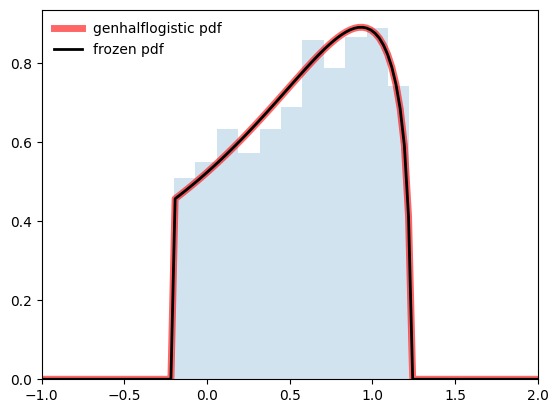

In [14]:

from scipy.stats import genhalflogistic
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
a = 0.77
mean, var, skew, kurt = genhalflogistic.stats(a, moments='mvsk')
loc = -0.2
scale = 1.1
x = np.linspace(-1, 2, 120)
ax.plot(x, genhalflogistic.pdf(x,a,loc=loc, scale=scale), 'r-', lw=5, alpha=0.6, label='genhalflogistic pdf')
rv = genhalflogistic(a, loc=loc, scale=scale)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')
vals = genhalflogistic.ppf([0.001, 0.5, 0.999], a, loc=loc,scale=scale)
np.allclose([0.001, 0.5, 0.999], genhalflogistic.cdf(vals, a, loc=loc, scale=scale))
r = genhalflogistic.rvs(a, size=1000, loc=loc, scale=scale)
ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax.set_xlim([-1, 2])
ax.legend(loc='best', frameon=False)
plt.show()
#goal is to find acceleration that results in lowest power value.
def simulate_power_used(c1, c2, speed_initial, distance, current_speed_limit, trials=5):
    a = 0 #we know distance, need to find time
    score = 0
    v_f = 0
    current_trial = 0
    total_trials = 0
    while(current_trial < trials):
        r1 = genhalflogistic.rvs(0.77, size=1, loc=-0.35, scale=1.25)
        speed_range = current_speed_limit - speed_initial
        speed_final_sample = r1[0] * speed_range + speed_initial
        if(speed_final_sample < 0):
            continue
        a_calc = (speed_final_sample**2 - speed_initial**2) / (2*distance)
        try:
            time = 2*distance / (speed_final_sample + speed_initial)
            _, avg_elec_power, avg_tractive_power = energy_used_between_points(c1, c2, speed_initial, speed_final_sample, time)
            eff = avg_tractive_power / avg_elec_power if avg_elec_power > 0 else avg_elec_power / avg_tractive_power
            score_i = eff

            if score_i >= score:
                a = a_calc
                score = score_i
                v_f = speed_final_sample
                if score_i >= 0.3:
                    current_trial += 1
                total_trials +=1
                if(score_i > 0.85):
                    break
            else:
                total_trials +=1
            if total_trials > 50:
                break

            # print(f"Trial {current_trial}: Eff {round(eff,2) * 100}%, a_calc: {a_calc}, distance: {distance}, elec: {avg_elec_power}, trac: {avg_tractive_power}")
        except AssertionError:
            print(f"Trial {current_trial}: Invalid Samples, a_calc: {a_calc}, distance: {distance}")
            continue
        
    if score < 0.2:
        print(f"Total Trials {total_trials}. Score: {score}, a: {a}")
    return a, v_f

In [15]:
def simulate_energy_captured(c: Checkpoint, distance: float, current_time: datetime.datetime, speed_initial: float, current_speed_limit: float, trials=10):
    a = 0 #we know distance, need to find time
    score = 0
    v_f = 0
    current_trial = 0
    total_trials = 0
    t = 0
    while(current_trial < trials):
        r1 = genhalflogistic.rvs(0.77, size=1, loc=-0.35, scale=1.25)
        speed_range = current_speed_limit - speed_initial
        speed_final_sample = r1[0] * speed_range + speed_initial
        if(speed_final_sample <= 0):
            continue
        a_calc = (speed_final_sample**2 - speed_initial**2) / (2*distance)
        try:
            time = 2*distance / (speed_final_sample + speed_initial)
            energy_in = energy_captured_between_points(c, current_time, time)

            score_i: float = energy_in
            if score_i >= score:
                a = a_calc
                score = score_i
                v_f = speed_final_sample
                t = time
                current_trial += 1
                total_trials += 1
            else:
                total_trials += 1
            if total_trials > 50:
                break

            # print(f"Trial {current_trial}: Score {round(score_i,2)}, a_calc: {a_calc}, distance: {distance}")
        except AssertionError:
            print(f"Trial {current_trial}: Invalid Samples, a_calc: {a_calc}, distance: {distance}")
            continue
        
    print(f"Total Trials {total_trials}. Score: {score}, a: {a}")
    return a, v_f,t

In [16]:
def assign_velocities(route: Route, time_initial:datetime.datetime, speed_limits: dict):
    current_time = time_initial
    #assert average_velocity > 35 mph
    velocities = [0]
    j = 0
    speed_limit_keys = list(speed_limits.keys())
    for i in range(1, len(route.checkpoints) - 1):
        if (j < len(speed_limits.keys())):
            speed_limit_ends_at = speed_limit_keys[j+1] * 1.60934
            if(route.checkpoints[i].distance / 1000 >= speed_limit_ends_at):
                j+=1
        if i == 0:
            velocities.append(0)
        else:
            current_speed_limit = speed_limits[speed_limit_keys[j]] * 1.60934 / 3.6#convert to m/s
            distance = route.checkpoints[i].distance - route.checkpoints[i-1].distance #meters
            current_velocity = velocities[i-1] / 3.6
            start = time.time()
            _, final_velocity = simulate_power_used(route.checkpoints[i-1], route.checkpoints[i], current_velocity, distance, current_speed_limit)
            _, final_velocity_2, _ = simulate_energy_captured(route.checkpoints[i-1], distance, current_time, current_velocity, current_speed_limit)
            end= time.time()
            weighted_v = final_velocity * 0.9 + final_velocity_2 * 0.1
            t = distance / weighted_v
            print(f'{(end-start)*1000} ms')
            current_time += datetime.timedelta(seconds=t)
            velocities.append(weighted_v * 3.6)
    velocities.append(0)
    return velocities

In [27]:
route = load_csv("A. Independence to Topeka")
loc_dt = datetime.datetime(2023, 6, 1, 8, 0, 0, tzinfo=est)
utc_dt = loc_dt.astimezone(utc)

velocities = assign_velocities(route, loc_dt, speed_limits)
avg_v = average_velocity(route, velocities)
print("avg v: ", avg_v)


Total Trials 51. Score: 7.481871158905831, a: 0.00020782111499707652
75.00457763671875 ms
Total Trials 51. Score: 0.9753923657562594, a: -0.04539355836842506
37.00852394104004 ms
Total Trials 51. Score: 0.2870403471060046, a: -0.09821218771108499
44.00992393493652 ms
Total Trials 51. Score: 0.04324922339264444, a: -0.3411333327683386
49.01123046875 ms
Total Trials 51. Score: 0.032213225200404406, a: -0.34177136486367593
39.010047912597656 ms
Total Trials 51. Score: 0.039834685410254714, a: -0.19216454053114881
47.00922966003418 ms
Total Trials 51. Score: 0.06019068146464082, a: -0.10423153663290431
47.00970649719238 ms
Total Trials 51. Score: 0.10869606873920185, a: -0.03302436377548912
48.01297187805176 ms
Total Trials 51. Score: 0.05000000000000001, a: -0.006170841624699261
Total Trials 51. Score: 0.10052216954778974, a: -0.00815011524987329
40.01498222351074 ms
Total Trials 51. Score: 0.02277261155804165, a: -0.0423970853084079
36.014556884765625 ms
Total Trials 51. Score: 0.0304863

KeyboardInterrupt: 

In [18]:
e1, power_outs = energy_used_along_route(route, velocities)
print("energy used (wh): ", e1)
e2, power_ins = energy_captured_along_route(utc_dt, velocities, route)
print("energy captured (wh): ", e2)
print(max(power_outs), min(power_outs), max(power_ins), min(power_ins))
print(len(route.checkpoints), len(power_ins), len(power_outs), len(velocities))

energy used (wh):  2723.1968899475155
energy captured (wh):  641.3197424449019
88319.84563861768 -21207.4561739234 535.1093314252921 0
2574 2574 2574 2574


In [25]:
import folium
import branca.colormap
import pandas as pd
def route_to_list(route: Route):
    coords: list[tuple[float, float]] = [] 
    for checkpoint in route.checkpoints:
        coords.append((checkpoint.lat, checkpoint.lon))
    return coords

def create_map(route: Route, values: list, diverging = True):
    coords = route_to_list(route)
    m = folium.Map()
    if diverging:
        colors: list = branca.colormap.linear.RdYlGn_04.colors
        colors.reverse()
        colormap = branca.colormap.LinearColormap(colors=colors, vmin=min(values), vmax=max(values))
    else:
        colormap = branca.colormap.linear.YlGnBu_07.scale(min(values), max(values)).to_step(7)
    tooltip = [f"{str(v)} | Value: {round(values[i])}" for (i,v) in enumerate(route.checkpoints)]
    for i in range(len(coords)-1):
        rgba = colormap.rgba_floats_tuple(values[i])
        rgba_scaled = (round(i*255) for i in rgba[0:3])
        # print('#{:02x}{:02x}{:02x}'.format(*rgba_scaled))
        folium.PolyLine(locations=[coords[i], coords[i+1]], tooltip=tooltip[i], weight=10, color='#{:02x}{:02x}{:02x}'.format(*rgba_scaled)).add_to(m)
    # folium.ColorLine(positions=coords, colormap=colormap, weight=5, colors=power_list).add_to(m)
    # for i,p in zip_longest(power_list, coords, fillvalue=np.mean(power_list)):
    #     folium.Marker(p, tooltip = i).add_to(m)
    df = pd.DataFrame(coords).rename(columns={0: 'lat', 1: 'lon'})
    sw = df[['lat', 'lon']].min().values.tolist()
    ne = df[['lat', 'lon']].max().values.tolist()
    m.fit_bounds([sw, ne])
    m.add_child(colormap)
    return m
# m1 = create_map(route, powers_in)
m = create_map(route, velocities, False)
m

In [37]:
def next_instruction(current_time: datetime.datetime, current_charge, current_lat: float, current_lon: float, current_route, speed_limits : dict, next_checkp, oint_close_hours, next_checkpoint_close_minutes):
    route = load_csv(current_route)
    velocities = assign_velocities(current_route, current_time, speed_limits)

    next_checkpoint = route.checkpoints[-1]
    
    current_index, current_placemark = closest_checkpoint_in_route(current_route, current_lat, current_lon)

    uncovered_route = Route('uncovered_route', current_route.checkpoints[index:])
    # How is current_energy calculated from the current_charge?
    current_energy = current_charge # This is wrong, but how to fix it?
    need_to_charge, max_reachable_placemark, max_index = find_max_reachable_placemark(current_index, current_time, current_route, current_energy, speed_limits)
    
    distance_in_between = max_reachable_placemark.distance - current_placemark.distance
    velocities = assign_velocities(Route('max_sub_route', uncovered_route.checkpoints[current_index:max_index]))
    
    
    # we assume that the close_time is on the same day as the the current time                  note: 24-hour clock so 1:00pm would be 13 for hours
    close_time = datetime.datetime(current_time.year, current_time.month, current_time.day, next_checkpoint_close_hours, next_checkpoint_close_minutes)
    
    # if the estimated amount of time that it will take is less than the amount allowed, then time is not an issue
    if (distance_in_between/average_velocity(route, velocities) < close_time - current_time):
        if (need_to_charge):
            print("Go to the following placemark at the following coordinates:", max_reachable_placemark.lat, max_reachable_placemark.lon)
            print("Then charge the vehicle")
        else:
            print("You have enough charge to make it to the next checkpoint, located at:", max_reachable_placemark.lat, max_reachable_placemark.lon)
            print("You will have this much charge left: ", current_charge) # this is wrong I haven't changed the value but how would I find the estimated charge at the end
            # using the energy values? how to convert energy back into charge
            # this function should return the predicted charge and time at the end of completion of this instruction
    else:
        print("You don't have enough time")
        # there are two cases here: you dont have enough charge or time to reach the checkpoint, or you have enough charge but not enough time
        # maybe different velocities are required now


def find_max_reachable_placemark(curr_placemark_index, curr_time, route, energy, speed_lim):
    for i in range(max(2, curr_placemark_index), len(route)):
        sub_route = Route('sub_route', current_route.checkpoints[:i])
        vel = assign_velocities(sub_route, curr_time, speed_lim)
        if (current_energy + energy_captured_along_route(current_time, sub_route, vel) - energy_used_along_route(sub_route, vel) < 0):
            return [True, current_route.checkpoints[i-1], i]
    #if the for loop ran to completion that means there's enough energy to reach the next checkpoint
    return [False, route.checkpoints[-1], len(route)-1]

def closest_checkpoint_in_route(route, lat, lon):
    #initial placeholder values
    closest_checkpoint = route.checkpoints[0]
    min_distance = heversine_and_azimuth(closest_checkpoint.lon, closest_checkpoint.lat, lon, lat)
    min_index = 0

    for index, curr_checkpoint in enumerate(route.checkpoints):
        distance = heversine_and_azimuth(curr_checkpoint.lon, curr_checkpoint.lat, lon, lat)
        if distance < min_distance:
            min_distance = distance
            min_index = index
            closest_checkpoint = curr_checkpoint
    return index, closest_checkpoint

In [38]:
route = load_csv("A. Independence to Topeka")
point_in_route = route.checkpoints[10]

next_instruction
loc_dt = datetime.datetime(2023, 6, 1, 8, 0, 0, tzinfo=est)
utc_dt = loc_dt.astimezone(utc)

#display_day_plan()